In [1]:
!pip install keras-nightly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 17.0 MB/s eta 0:00:00


In [2]:
import pandas as pd
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, Reshape, Multiply, Add, ReLU, GlobalMaxPooling2D, Lambda, Concatenate
from keras.optimizers import Adam
from keras.applications import VGG16, InceptionV3
from tensorflow.keras import backend as K
import numpy as np
import time
import matplotlib.image as mpimg
import random

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#Set fixed seeds
random.seed(45)
np.random.seed(45)
tf.random.set_seed(45)

In [ ]:
dataset_path = '/content/drive/MyDrive/Reverse'

In [ ]:
image_size = (299, 299)

# Create a data generator
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Load training data
train_data = datagen.flow_from_directory(
    dataset_path,
    target_size=image_size,
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=False,
    seed=45
)

# Load validation data
val_data = datagen.flow_from_directory(
    dataset_path,
    target_size=image_size,
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    seed=45
)

Number of images in class 60: 100
Randomly selected image: 58.png


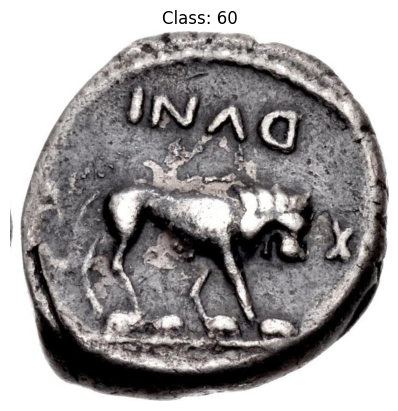

In [ ]:
class_name = '60'

# Path to the specific class folder
class_folder = os.path.join(dataset_path, class_name)

# Check the contents of the folder
images = os.listdir(class_folder)
print(f"Number of images in class {class_name}: {len(images)}")
# Randomly sample an image
random_image = random.choice(images)
random_image_path = os.path.join(class_folder, random_image)

print(f"Randomly selected image: {random_image}")
# Read and plot the image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.axis('off')
plt.title(f"Class: {class_name}")
plt.show()

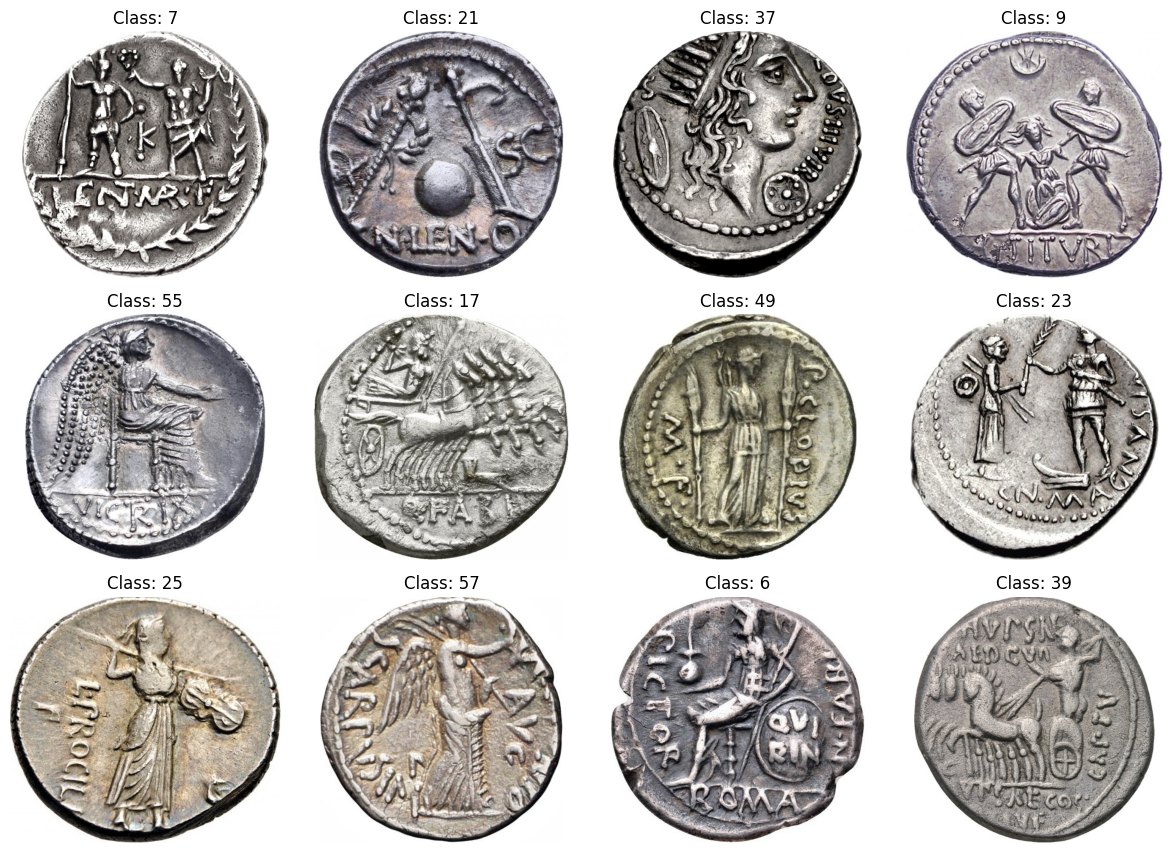

In [ ]:
# Get all class folders
class_folders = sorted(os.listdir(dataset_path))

# Randomly sample 12 different classes
selected_classes = random.sample(class_folders, 12)

# Create a figure for plotting
fig, axes = plt.subplots(3, 4, figsize=(12, 9))
#fig.suptitle("Random Images from 12 Different Classes", fontsize=16)

for ax, class_name in zip(axes.flatten(), selected_classes):
    class_folder = os.path.join(dataset_path, class_name)
    images = os.listdir(class_folder)
    if images:  # Ensure there are images in the class folder
        random_image = random.choice(images)
        random_image_path = os.path.join(class_folder, random_image)
        img = mpimg.imread(random_image_path)

        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f"Class: {class_name}")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig("images_plot.png")  # Save the plot as an image file
plt.show()

#Frozen Base Model

In [ ]:
# Define the base model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

for layer in base_model.layers:
    layer.trainable = False

base_model.summary()

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "inception_v3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 299, 299, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 149, 149, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 149, 149, 32)   │             96 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 149, 149, 32)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 147, 147, 32)   │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 147, 147, 32)   │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 147, 147, 32)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 147, 147, 64)   │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 147, 147, 64)   │            192 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 147, 147, 64)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 73, 73, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 73, 73, 80)     │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 73, 73, 80)     │            240 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 73, 73, 80)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 71, 71, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 71, 71, 192)    │            576 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activat

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 21,802,784 (83.17 MB)

##Model1

In [ ]:
#Define the model

model1 = Sequential([
   # keras.Input(shape=(299, 299, 3)),
   # data_augmentation,
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    #Dropout(0.30),
    Dense(128, activation='relu'),
    #Dropout(0.30),
    Dense(60, activation='softmax')
])

In [ ]:
model1.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
early_stop = [keras.callbacks.EarlyStopping(monitor="val_loss", patience=3)]

Epoch 1/40


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


151/151 ━━━━━━━━━━━━━━━━━━━━ 136s 731ms/step - accuracy: 0.1055 - loss: 3.7856 - val_accuracy: 0.4292 - val_loss: 2.2582
Epoch 2/40
151/151 ━━━━━━━━━━━━━━━━━━━━ 89s 569ms/step - accuracy: 0.5285 - loss: 1.8413 - val_accuracy: 0.6708 - val_loss: 1.2781
Epoch 3/40
151/151 ━━━━━━━━━━━━━━━━━━━━ 89s 567ms/step - accuracy: 0.7218 - loss: 1.0554 - val_accuracy: 0.7250 - val_loss: 0.9823
Epoch 4/40
151/151 ━━━━━━━━━━━━━━━━━━━━ 89s 565ms/step - accuracy: 0.7928 - loss: 0.7707 - val_accuracy: 0.7708 - val_loss: 0.8477
Epoch 5/40
151/151 ━━━━━━━━━━━━━━━━━━━━ 140s 560ms/step - accuracy: 0.8526 - loss: 0.5557 - val_accuracy: 0.8008 - val_loss: 0.7204
Epoch 6/40
151/151 ━━━━━━━━━━━━━━━━━━━━ 88s 564ms/step - accuracy: 0.8885 - loss: 0.4262 - val_accuracy: 0.8292 - val_loss: 0.6225
Epoch 7/40
151/151 ━━━━━━━━━━━━━━━━━━━━ 142s 568ms/step - accuracy: 0.9015 - loss: 0.3779 - val_accuracy: 0.8200 - val_loss: 0.6283
Epoch 8/40
151/151 ━━━━━━━━━━━━━━━━━━━━ 88s 564ms/step - accuracy: 0.9210 - loss: 0.3101 - 

Test Loss: 0.5251907110214233
Test Accuracy: 0.8700000047683716


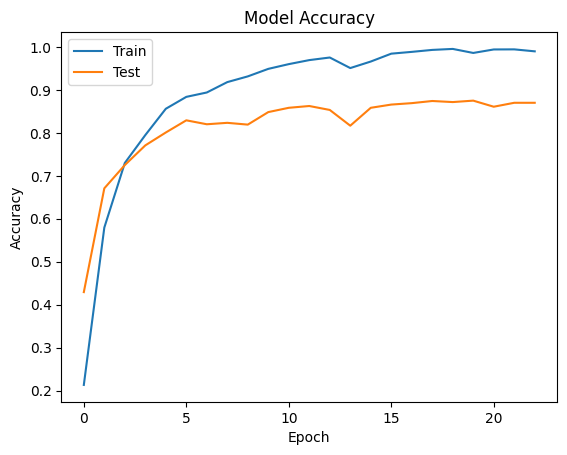

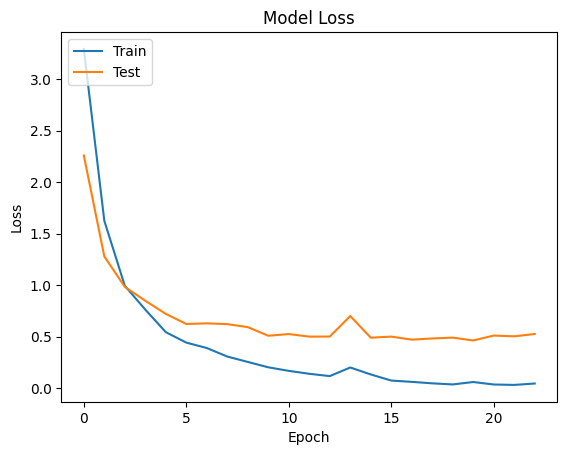

In [ ]:
history = model1.fit(
    x = train_data,
    epochs=40,
    validation_data=val_data,
    callbacks=early_stop
)

test_loss, test_accuracy = model1.evaluate(val_data)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)
models_path='/content/drive/My Drive/Thesis_Models/InceptionV3BasedModel.h5'
model1.save(models_path)


# Plot training and test accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training and test loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

#Model2

In [ ]:
#Define the model2

model2 = Sequential([
    #keras.Input(shape=(299, 299, 3)),
    #data_augmentation,
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.10),
    Dense(128, activation='relu'),
    Dropout(0.10),
    Dense(60, activation='softmax')
])

In [ ]:
model2.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
early_stop = [keras.callbacks.EarlyStopping(monitor="val_loss", patience=3)]

Epoch 1/40


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


151/151 ━━━━━━━━━━━━━━━━━━━━ 2532s 16s/step - accuracy: 0.0667 - loss: 3.9283 - val_accuracy: 0.3675 - val_loss: 2.7302
Epoch 2/40
151/151 ━━━━━━━━━━━━━━━━━━━━ 75s 478ms/step - accuracy: 0.3290 - loss: 2.5351 - val_accuracy: 0.5875 - val_loss: 1.6113
Epoch 3/40
151/151 ━━━━━━━━━━━━━━━━━━━━ 75s 474ms/step - accuracy: 0.5547 - loss: 1.5946 - val_accuracy: 0.7050 - val_loss: 1.1053
Epoch 4/40
151/151 ━━━━━━━━━━━━━━━━━━━━ 75s 477ms/step - accuracy: 0.6565 - loss: 1.1508 - val_accuracy: 0.7567 - val_loss: 0.9171
Epoch 5/40
151/151 ━━━━━━━━━━━━━━━━━━━━ 75s 476ms/step - accuracy: 0.7313 - loss: 0.9314 - val_accuracy: 0.8008 - val_loss: 0.7593
Epoch 6/40
151/151 ━━━━━━━━━━━━━━━━━━━━ 74s 473ms/step - accuracy: 0.7811 - loss: 0.7437 - val_accuracy: 0.8108 - val_loss: 0.7002
Epoch 7/40
151/151 ━━━━━━━━━━━━━━━━━━━━ 75s 479ms/step - accuracy: 0.8037 - loss: 0.6740 - val_accuracy: 0.8175 - val_loss: 0.6560
Epoch 8/40
151/151 ━━━━━━━━━━━━━━━━━━━━ 75s 480ms/step - accuracy: 0.8329 - loss: 0.5426 - val

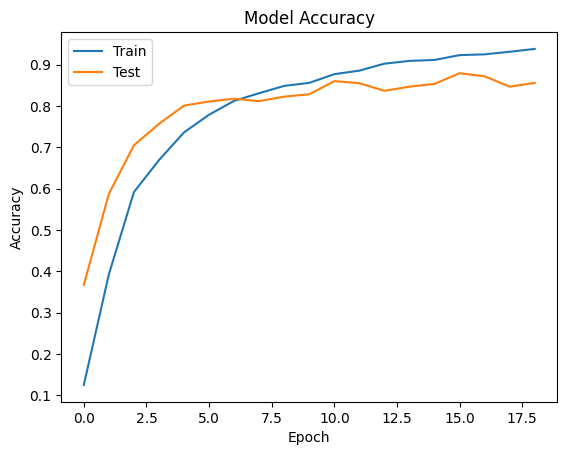

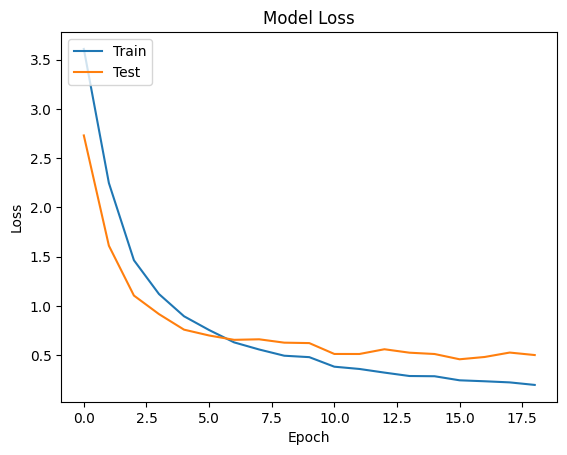

In [ ]:
history = model2.fit(
    x = train_data,
    epochs=40,
    validation_data=val_data,
    callbacks=early_stop
)

test_loss, test_accuracy = model2.evaluate(val_data)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)
models_path='/content/drive/My Drive/Thesis_Models/InceptionV3BasedModel2.keras'
model2.save(models_path)


# Plot training and test accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training and test loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

#Model3

In [ ]:
# Define the base model
trainable_base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

for layer in trainable_base_model.layers[-31:]:
  layer.trainable = True

for layer in trainable_base_model.layers[:-31]:
  layer.trainable = False

trainable_base_model.summary()

Model: "inception_v3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 299, 299, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_94 (Conv2D)        │ (None, 149, 149, 32)   │            864 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_94    │ (None, 149, 149, 32)   │             96 │ conv2d_94[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_94             │ (None, 149, 149, 32)   │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_95 (Conv2D)        │ (None, 147, 147, 32)   │          9,216 │ activation_94[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_95    │ (None, 147, 147, 32)   │             96 │ conv2d_95[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_95             │ (None, 147, 147, 32)   │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_96 (Conv2D)        │ (None, 147, 147, 64)   │         18,432 │ activation_95[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_96    │ (None, 147, 147, 64)   │            192 │ conv2d_96[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_96             │ (None, 147, 147, 64)   │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 73, 73, 64)     │              0 │ activation_96[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_97 (Conv2D)        │ (None, 73, 73, 80)     │          5,120 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_97    │ (None, 73, 73, 80)     │            240 │ conv2d_97[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_97             │ (None, 73, 73, 80)     │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_98 (Conv2D)   

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 6,073,536 (23.17 MB)

 Non-trainable params: 15,729,248 (60.00 MB)

In [ ]:
#Define the model3

model3 = Sequential([
    trainable_base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.10),
    Dense(128, activation='relu'),
    Dropout(0.10),
    Dense(60, activation='softmax')
])

In [ ]:
checkpoint_filepath1 = '/content/drive/My Drive/Thesis_Models/InceptionV3BasedModel3.keras'

In [ ]:
# Define callbacks
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model_checkpoint = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath1,
    monitor='val_loss',
    save_best_only=True
)

In [ ]:
model3.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


151/151 ━━━━━━━━━━━━━━━━━━━━ 5051s 32s/step - accuracy: 0.1913 - loss: 3.4995 - val_accuracy: 0.7500 - val_loss: 1.4398
Epoch 2/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 74s 474ms/step - accuracy: 0.7850 - loss: 1.0953 - val_accuracy: 0.9200 - val_loss: 0.4659
Epoch 3/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 74s 466ms/step - accuracy: 0.9265 - loss: 0.3900 - val_accuracy: 0.9342 - val_loss: 0.2970
Epoch 4/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 74s 468ms/step - accuracy: 0.9687 - loss: 0.1944 - val_accuracy: 0.9458 - val_loss: 0.2373
Epoch 5/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 74s 468ms/step - accuracy: 0.9814 - loss: 0.1148 - val_accuracy: 0.9508 - val_loss: 0.2150
Epoch 6/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 73s 461ms/step - accuracy: 0.9926 - loss: 0.0626 - val_accuracy: 0.9183 - val_loss: 0.3110
Epoch 7/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 73s 467ms/step - accuracy: 0.9909 - loss: 0.0779 - val_accuracy: 0.9492 - val_loss: 0.2019
Epoch 8/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 74s 469ms/step - accuracy: 0.9947 - loss: 0.0360 - val

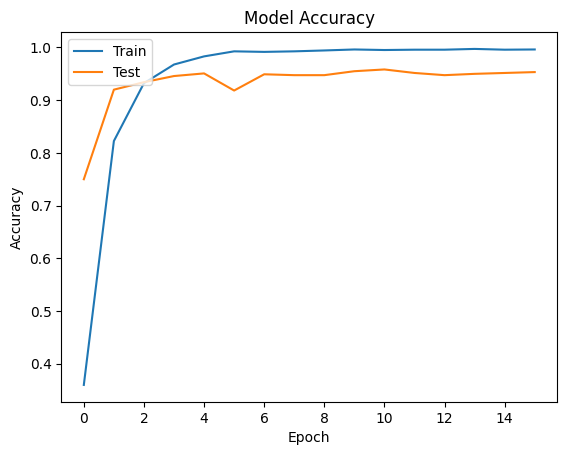

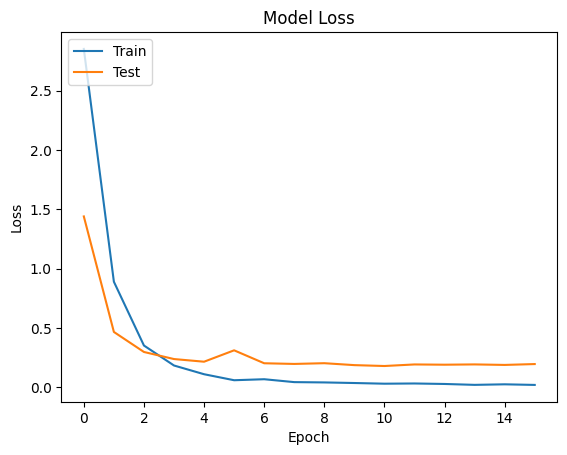

In [ ]:
history = model3.fit(
    x = train_data,
    epochs=50,
    validation_data=val_data,
    callbacks=[early_stopping, model_checkpoint]
)

test_loss, test_accuracy = model3.evaluate(val_data)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)


# Plot training and test accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training and test loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

#Model4 (1 SE Block)

In [ ]:
# Define the base model
trainable_base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

for layer in trainable_base_model.layers[-31:]:
  layer.trainable = True

for layer in trainable_base_model.layers[:-31]:
  layer.trainable = False

trainable_base_model.summary()

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "inception_v3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 299, 299, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 149, 149, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 149, 149, 32)   │             96 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 149, 149, 32)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 147, 147, 32)   │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 147, 147, 32)   │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 147, 147, 32)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 147, 147, 64)   │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 147, 147, 64)   │            192 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 147, 147, 64)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 73, 73, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 73, 73, 80)     │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 73, 73, 80)     │            240 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 73, 73, 80)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 71, 71, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 71, 71, 192)    │            576 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activat

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 6,073,536 (23.17 MB)

 Non-trainable params: 15,729,248 (60.00 MB)

In [ ]:
def squeeze_excite_block(input_tensor, ratio):
    """
    Create a Squeeze-and-Excitation block.

    Args:
        input_tensor: Input Keras tensor (e.g., output of a convolutional layer).
        ratio: Reduction ratio for the bottleneck (usually 16).

    Returns:
        Keras tensor after applying the SE block.
    """
    # Get the number of channels in the input tensor
    channel_axis = -1  # TensorFlow/Keras uses channel_last format
    channels = input_tensor.shape[channel_axis]

    # Squeeze: Global Average Pooling
    se = GlobalAveragePooling2D()(input_tensor)

    # Excitation: Bottleneck structure
    se = Dense(channels // ratio, activation='relu')(se)  # Bottleneck (reduce channels)
    se = Dense(channels, activation='sigmoid')(se)       # Restore channels

    # Reshape to match the input tensor dimensions
    se = Reshape((1, 1, channels))(se)

    # Recalibrate: Scale the input tensor with the channel-wise weights
    x = Multiply()([input_tensor, se])

    return x

In [ ]:
#Code for the whole process
x = trainable_base_model.output
x = squeeze_excite_block(x, 16)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.10)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.10)(x)
output_tensor = Dense(60, activation='softmax')(x)

In [ ]:
#Final Model
model4 = Model(inputs=trainable_base_model.input, outputs=output_tensor)
model4.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model4.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 299, 299, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 149, 149, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 149, 149, 32)   │             96 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 149, 149, 32)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 147, 147, 32)   │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 147, 147, 32)   │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 147, 147, 32)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 147, 147, 64)   │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 147, 147, 64)   │            192 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 147, 147, 64)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 73, 73, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 73, 73, 80)     │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 73, 73, 80)     │            240 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 73, 73, 80)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 71, 71, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 71, 71, 192)    │            576 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activat

 Total params: 22,894,428 (87.34 MB)

 Trainable params: 7,165,180 (27.33 MB)

 Non-trainable params: 15,729,248 (60.00 MB)

In [ ]:
checkpoint_filepath2 = '/content/drive/My Drive/Thesis_Models/InceptionV3BasedModel4.keras'

In [ ]:
# Define callbacks
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model_checkpoint = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath2,
    monitor='val_loss',
    save_best_only=True
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


151/151 ━━━━━━━━━━━━━━━━━━━━ 2737s 17s/step - accuracy: 0.1583 - loss: 3.6677 - val_accuracy: 0.5808 - val_loss: 1.6928
Epoch 2/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 72s 459ms/step - accuracy: 0.7381 - loss: 1.1736 - val_accuracy: 0.9050 - val_loss: 0.4369
Epoch 3/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 73s 460ms/step - accuracy: 0.9280 - loss: 0.3544 - val_accuracy: 0.9500 - val_loss: 0.2730
Epoch 4/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 73s 460ms/step - accuracy: 0.9722 - loss: 0.1670 - val_accuracy: 0.9500 - val_loss: 0.2423
Epoch 5/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 72s 458ms/step - accuracy: 0.9854 - loss: 0.0941 - val_accuracy: 0.9542 - val_loss: 0.2008
Epoch 6/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 72s 457ms/step - accuracy: 0.9873 - loss: 0.0722 - val_accuracy: 0.9525 - val_loss: 0.1958
Epoch 7/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 72s 453ms/step - accuracy: 0.9931 - loss: 0.0555 - val_accuracy: 0.9658 - val_loss: 0.1781
Epoch 8/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 71s 448ms/step - accuracy: 0.9990 - loss: 0.0206 - val

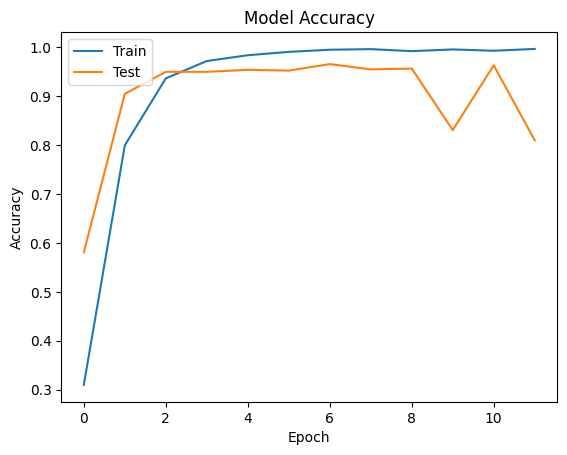

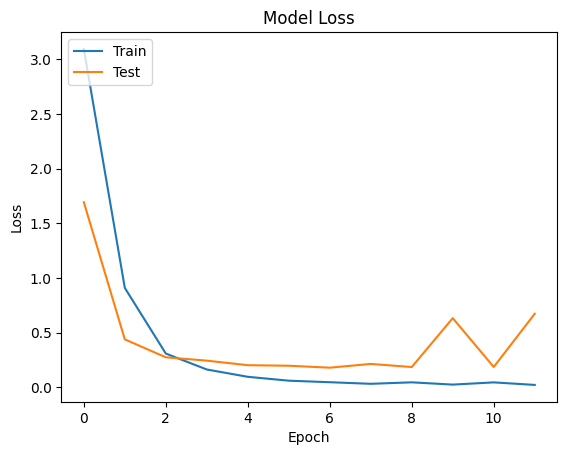

In [ ]:
history = model4.fit(
    x = train_data,
    epochs=50,
    validation_data=val_data,
    callbacks=[early_stopping, model_checkpoint]
)

test_loss, test_accuracy = model4.evaluate(val_data)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)


# Plot training and test accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training and test loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
# Measure inference time on L4 GPU
num_samples = len(val_data.filenames)
total_time = 0
num_batches = len(val_data)

# Load the trained model
model_path = '/content/drive/My Drive/Thesis_Models/InceptionV3BasedModel4.keras'
model = tf.keras.models.load_model(model_path)


for i in range(num_batches):
    images, _ = val_data[i]  # Get batch of images
    start_time = time.time()
    _ = model.predict(images, verbose=0)  # Run inference
    end_time = time.time()
    total_time += (end_time - start_time)

# Compute average inference time per image
avg_inference_time = total_time / num_samples
print(f'Average inference time per image: {avg_inference_time:.6f} seconds')

Average inference time per image: 0.030222 seconds


#Model5 (1 SEBlock with 20% of Dataset for Training)

In [ ]:
# Define the base model
trainable_base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

for layer in trainable_base_model.layers[-31:]:
  layer.trainable = True

for layer in trainable_base_model.layers[:-31]:
  layer.trainable = False

trainable_base_model.summary()

Model: "inception_v3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 299, 299, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_94 (Conv2D)        │ (None, 149, 149, 32)   │            864 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_94    │ (None, 149, 149, 32)   │             96 │ conv2d_94[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_94             │ (None, 149, 149, 32)   │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_95 (Conv2D)        │ (None, 147, 147, 32)   │          9,216 │ activation_94[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_95    │ (None, 147, 147, 32)   │             96 │ conv2d_95[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_95             │ (None, 147, 147, 32)   │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_96 (Conv2D)        │ (None, 147, 147, 64)   │         18,432 │ activation_95[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_96    │ (None, 147, 147, 64)   │            192 │ conv2d_96[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_96             │ (None, 147, 147, 64)   │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 73, 73, 64)     │              0 │ activation_96[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_97 (Conv2D)        │ (None, 73, 73, 80)     │          5,120 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_97    │ (None, 73, 73, 80)     │            240 │ conv2d_97[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_97             │ (None, 73, 73, 80)     │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_98 (Conv2D)   

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 6,073,536 (23.17 MB)

 Non-trainable params: 15,729,248 (60.00 MB)

In [ ]:
def squeeze_excite_block(input_tensor, ratio):
    """
    Create a Squeeze-and-Excitation block.

    Args:
        input_tensor: Input Keras tensor (e.g., output of a convolutional layer).
        ratio: Reduction ratio for the bottleneck (usually 16).

    Returns:
        Keras tensor after applying the SE block.
    """
    # Get the number of channels in the input tensor
    channel_axis = -1  # TensorFlow/Keras uses channel_last format
    channels = input_tensor.shape[channel_axis]

    # Squeeze: Global Average Pooling
    se = GlobalAveragePooling2D()(input_tensor)

    # Excitation: Bottleneck structure
    se = Dense(channels // ratio, activation='relu')(se)  # Bottleneck (reduce channels)
    se = Dense(channels, activation='sigmoid')(se)       # Restore channels

    # Reshape to match the input tensor dimensions
    se = Reshape((1, 1, channels))(se)

    # Recalibrate: Scale the input tensor with the channel-wise weights
    x = Multiply()([input_tensor, se])

    return x

In [ ]:
#Code for the whole process
x = trainable_base_model.output
x = squeeze_excite_block(x, 16)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.10)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.10)(x)
output_tensor = Dense(60, activation='softmax')(x)

In [ ]:
#Final Model
model5 = Model(inputs=trainable_base_model.input, outputs=output_tensor)
model5.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model5.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 299, 299, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_94 (Conv2D)        │ (None, 149, 149, 32)   │            864 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_94    │ (None, 149, 149, 32)   │             96 │ conv2d_94[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_94             │ (None, 149, 149, 32)   │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_95 (Conv2D)        │ (None, 147, 147, 32)   │          9,216 │ activation_94[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_95    │ (None, 147, 147, 32)   │             96 │ conv2d_95[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_95             │ (None, 147, 147, 32)   │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_96 (Conv2D)        │ (None, 147, 147, 64)   │         18,432 │ activation_95[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_96    │ (None, 147, 147, 64)   │            192 │ conv2d_96[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_96             │ (None, 147, 147, 64)   │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 73, 73, 64)     │              0 │ activation_96[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_97 (Conv2D)        │ (None, 73, 73, 80)     │          5,120 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_97    │ (None, 73, 73, 80)     │            240 │ conv2d_97[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_97             │ (None, 73, 73, 80)     │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_98 (Conv2D)   

 Total params: 22,894,428 (87.34 MB)

 Trainable params: 7,165,180 (27.33 MB)

 Non-trainable params: 15,729,248 (60.00 MB)

In [ ]:
checkpoint_filepath = '/content/drive/My Drive/Thesis_Models/20%InceptionV3BasedModel4.keras'

In [ ]:
# Define callbacks
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model_checkpoint = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    save_best_only=True
)

In [ ]:
def reduce_train_dataset(generator, fraction):
    """
    Reduces a dataset generator to a smaller balanced fraction and uses folder names as class labels.
    Args:
        generator: Original data generator.
        fraction: Fraction of the dataset to retain (total fraction of the dataset).
    Returns:
        A balanced reduced dataset with folder names as class labels.
    """
    total_samples = generator.samples  # Total number of samples in the generator
    classes = generator.classes        # Class labels from the generator
    filepaths = np.array(generator.filepaths)  # File paths for all samples
    unique_classes = np.unique(classes)  # Unique numerical class labels

    # Compute the number of samples per class to retain
    samples_per_class = int((total_samples * fraction) / len(unique_classes))

    reduced_data = []
    reduced_labels = []

    # Create a mapping from numerical labels to folder names
    folder_labels = {
        cls: os.path.basename(os.path.dirname(filepaths[np.where(classes == cls)[0][0]]))
        for cls in unique_classes
    }

    # For each class, sample the required number of images
    for cls in unique_classes:
        cls_indices = np.where(classes == cls)[0]
        sampled_indices = np.random.choice(cls_indices, samples_per_class, replace=False)
        reduced_data.extend(filepaths[sampled_indices])
        reduced_labels.extend([folder_labels[cls]] * len(sampled_indices))  # Use folder names as labels

    return reduced_data, reduced_labels

In [ ]:
# Reduce the dataset to a balanced subset with folder names as class labels
reduced_data, reduced_labels = reduce_train_dataset(train_data, fraction=0.25)

# Create a dataframe for the reduced dataset
reduced_df = pd.DataFrame({'filename': reduced_data, 'class': reduced_labels})

# Create a new generator for the reduced training set
reduced_train_data = ImageDataGenerator(rescale=1./255).flow_from_dataframe(
    dataframe=reduced_df,
    x_col='filename',
    y_col='class',
    target_size=image_size,
    batch_size=32,
    class_mode='categorical',
    shuffle=False,
    seed=45
)

Found 1200 validated image filenames belonging to 60 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1707s 45s/step - accuracy: 0.0423 - loss: 4.0421 - val_accuracy: 0.1217 - val_loss: 3.9044
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 28s 739ms/step - accuracy: 0.3070 - loss: 3.4976 - val_accuracy: 0.2983 - val_loss: 3.3682
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 29s 754ms/step - accuracy: 0.4807 - loss: 2.6764 - val_accuracy: 0.5683 - val_loss: 2.3006
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 29s 767ms/step - accuracy: 0.7684 - loss: 1.4690 - val_accuracy: 0.7333 - val_loss: 1.3104
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 28s 748ms/step - accuracy: 0.9002 - loss: 0.6426 - val_accuracy: 0.8242 - val_loss: 0.8776
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 28s 739ms/step - accuracy: 0.9763 - loss: 0.2999 - val_accuracy: 0.8392 - val_loss: 0.7356
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 28s 743ms/step - accuracy: 0.9860 - loss: 0.1577 - val_accuracy: 0.8642 - val_loss: 0.6300
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 28s 753ms/step - accuracy: 0.9991 - loss: 0.0998 - val_accu

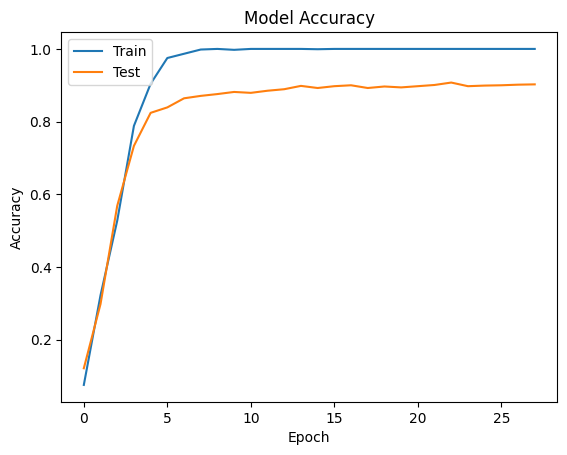

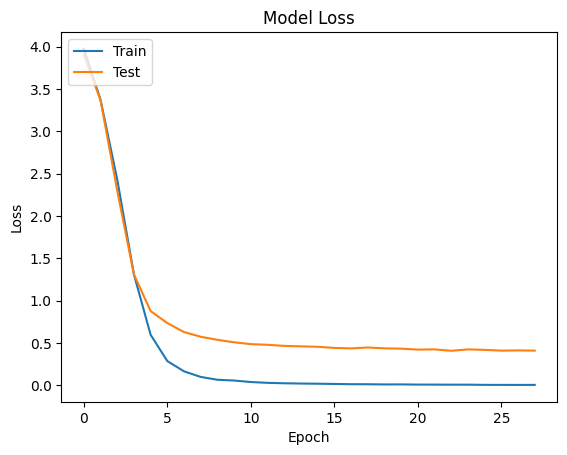

In [ ]:
history = model5.fit(
    x = reduced_train_data,
    epochs=50,
    validation_data=val_data,
    callbacks=[early_stopping, model_checkpoint]
)

test_loss, test_accuracy = model5.evaluate(val_data)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)


# Plot training and test accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training and test loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

#Model6 (1 SEBlock with 10% of Dataset for Training)

In [ ]:
# Define the base model
trainable_base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

for layer in trainable_base_model.layers[-31:]:
  layer.trainable = True

for layer in trainable_base_model.layers[:-31]:
  layer.trainable = False

trainable_base_model.summary()

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "inception_v3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 299, 299, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 149, 149, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 149, 149, 32)   │             96 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 149, 149, 32)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 147, 147, 32)   │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 147, 147, 32)   │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 147, 147, 32)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 147, 147, 64)   │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 147, 147, 64)   │            192 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 147, 147, 64)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 73, 73, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 73, 73, 80)     │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 73, 73, 80)     │            240 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 73, 73, 80)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 71, 71, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 71, 71, 192)    │            576 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activat

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 6,073,536 (23.17 MB)

 Non-trainable params: 15,729,248 (60.00 MB)

In [ ]:
def squeeze_excite_block(input_tensor, ratio):
    """
    Create a Squeeze-and-Excitation block.

    Args:
        input_tensor: Input Keras tensor (e.g., output of a convolutional layer).
        ratio: Reduction ratio for the bottleneck (usually 16).

    Returns:
        Keras tensor after applying the SE block.
    """
    # Get the number of channels in the input tensor
    channel_axis = -1  # TensorFlow/Keras uses channel_last format
    channels = input_tensor.shape[channel_axis]

    # Squeeze: Global Average Pooling
    se = GlobalAveragePooling2D()(input_tensor)

    # Excitation: Bottleneck structure
    se = Dense(channels // ratio, activation='relu')(se)  # Bottleneck (reduce channels)
    se = Dense(channels, activation='sigmoid')(se)       # Restore channels

    # Reshape to match the input tensor dimensions
    se = Reshape((1, 1, channels))(se)

    # Recalibrate: Scale the input tensor with the channel-wise weights
    x = Multiply()([input_tensor, se])

    return x

In [ ]:
#Code for the whole process
x = trainable_base_model.output
x = squeeze_excite_block(x, 16)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.10)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.10)(x)
output_tensor = Dense(60, activation='softmax')(x)

In [ ]:
#Final Model
model6 = Model(inputs=trainable_base_model.input, outputs=output_tensor)
model6.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model6.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 299, 299, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 149, 149, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 149, 149, 32)   │             96 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 149, 149, 32)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 147, 147, 32)   │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 147, 147, 32)   │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 147, 147, 32)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 147, 147, 64)   │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 147, 147, 64)   │            192 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 147, 147, 64)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 73, 73, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 73, 73, 80)     │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 73, 73, 80)     │            240 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 73, 73, 80)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 71, 71, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 71, 71, 192)    │            576 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activat

 Total params: 22,894,428 (87.34 MB)

 Trainable params: 7,165,180 (27.33 MB)

 Non-trainable params: 15,729,248 (60.00 MB)

In [ ]:
checkpoint_filepath = '/content/drive/My Drive/Thesis_Models/10%InceptionV3BasedModel4.keras'

In [ ]:
# Define callbacks
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model_checkpoint = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    save_best_only=True
)

In [ ]:
def reduce_train_dataset(generator, fraction):
    """
    Reduces a dataset generator to a smaller balanced fraction and uses folder names as class labels.
    Args:
        generator: Original data generator.
        fraction: Fraction of the dataset to retain (total fraction of the dataset).
    Returns:
        A balanced reduced dataset with folder names as class labels.
    """
    total_samples = generator.samples  # Total number of samples in the generator
    classes = generator.classes        # Class labels from the generator
    filepaths = np.array(generator.filepaths)  # File paths for all samples
    unique_classes = np.unique(classes)  # Unique numerical class labels

    # Compute the number of samples per class to retain
    samples_per_class = int((total_samples * fraction) / len(unique_classes))

    reduced_data = []
    reduced_labels = []

    # Create a mapping from numerical labels to folder names
    folder_labels = {
        cls: os.path.basename(os.path.dirname(filepaths[np.where(classes == cls)[0][0]]))
        for cls in unique_classes
    }

    # For each class, sample the required number of images
    for cls in unique_classes:
        cls_indices = np.where(classes == cls)[0]
        sampled_indices = np.random.choice(cls_indices, samples_per_class, replace=False)
        reduced_data.extend(filepaths[sampled_indices])
        reduced_labels.extend([folder_labels[cls]] * len(sampled_indices))  # Use folder names as labels

    return reduced_data, reduced_labels

In [ ]:
# Reduce the dataset to a balanced subset with folder names as class labels
reduced_data, reduced_labels = reduce_train_dataset(train_data, fraction=0.125)

# Create a dataframe for the reduced dataset
reduced_df = pd.DataFrame({'filename': reduced_data, 'class': reduced_labels})

# Create a new generator for the reduced training set
reduced_train_data = ImageDataGenerator(rescale=1./255).flow_from_dataframe(
    dataframe=reduced_df,
    x_col='filename',
    y_col='class',
    target_size=image_size,
    batch_size=32,
    class_mode='categorical',
    shuffle=False,
    seed=45
)

Found 600 validated image filenames belonging to 60 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1454s 78s/step - accuracy: 0.0393 - loss: 4.0754 - val_accuracy: 0.0867 - val_loss: 4.0243
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.2407 - loss: 3.7891 - val_accuracy: 0.1600 - val_loss: 3.8916
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.3603 - loss: 3.4416 - val_accuracy: 0.2175 - val_loss: 3.6905
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.5068 - loss: 2.9262 - val_accuracy: 0.3458 - val_loss: 3.3506
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.6465 - loss: 2.3452 - val_accuracy: 0.4175 - val_loss: 2.8901
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.7931 - loss: 1.5802 - val_accuracy: 0.5358 - val_loss: 2.3153
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.8969 - loss: 0.9860 - val_accuracy: 0.6650 - val_loss: 1.8199
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.9711 - loss: 0.5030 - val_accuracy: 0.6817 - val_lo

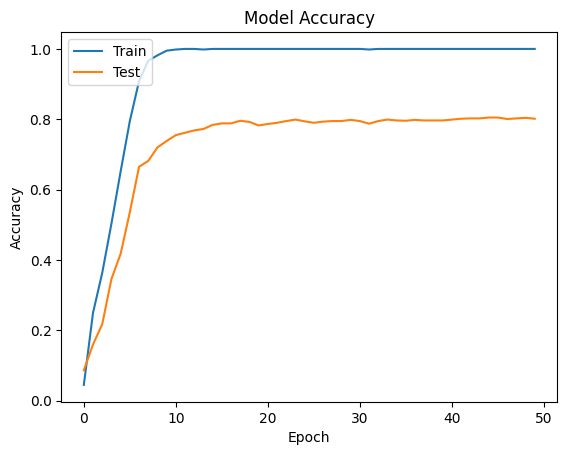

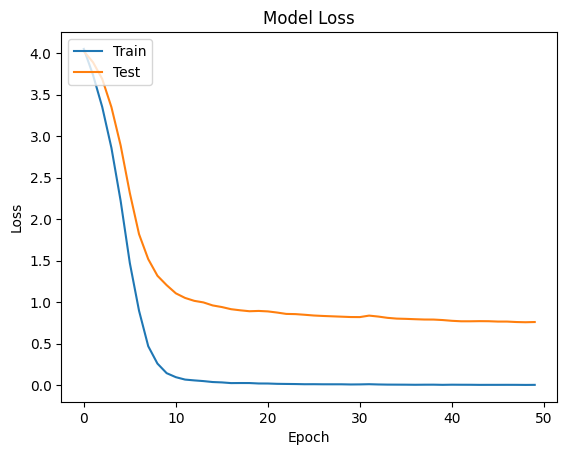

In [ ]:
history = model6.fit(
    x = reduced_train_data,
    epochs=50,
    validation_data=val_data,
    callbacks=[early_stopping, model_checkpoint]
)

test_loss, test_accuracy = model6.evaluate(val_data)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)


# Plot training and test accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training and test loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

#Model7 (1 SEBlock with 5% of Dataset for Training)

In [ ]:
# Define the base model
trainable_base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

for layer in trainable_base_model.layers[-31:]:
  layer.trainable = True

for layer in trainable_base_model.layers[:-31]:
  layer.trainable = False

trainable_base_model.summary()

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "inception_v3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 299, 299, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 149, 149, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 149, 149, 32)   │             96 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 149, 149, 32)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 147, 147, 32)   │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 147, 147, 32)   │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 147, 147, 32)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 147, 147, 64)   │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 147, 147, 64)   │            192 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 147, 147, 64)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 73, 73, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 73, 73, 80)     │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 73, 73, 80)     │            240 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 73, 73, 80)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 71, 71, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 71, 71, 192)    │            576 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activat

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 6,073,536 (23.17 MB)

 Non-trainable params: 15,729,248 (60.00 MB)

In [ ]:
def squeeze_excite_block(input_tensor, ratio):
    """
    Create a Squeeze-and-Excitation block.

    Args:
        input_tensor: Input Keras tensor (e.g., output of a convolutional layer).
        ratio: Reduction ratio for the bottleneck (usually 16).

    Returns:
        Keras tensor after applying the SE block.
    """
    # Get the number of channels in the input tensor
    channel_axis = -1  # TensorFlow/Keras uses channel_last format
    channels = input_tensor.shape[channel_axis]

    # Squeeze: Global Average Pooling
    se = GlobalAveragePooling2D()(input_tensor)

    # Excitation: Bottleneck structure
    se = Dense(channels // ratio, activation='relu')(se)  # Bottleneck (reduce channels)
    se = Dense(channels, activation='sigmoid')(se)       # Restore channels

    # Reshape to match the input tensor dimensions
    se = Reshape((1, 1, channels))(se)

    # Recalibrate: Scale the input tensor with the channel-wise weights
    x = Multiply()([input_tensor, se])

    return x

In [ ]:
#Code for the whole process
x = trainable_base_model.output
x = squeeze_excite_block(x, 16)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.10)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.10)(x)
output_tensor = Dense(60, activation='softmax')(x)

In [ ]:
#Final Model
model7 = Model(inputs=trainable_base_model.input, outputs=output_tensor)
model7.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model7.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 299, 299, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 149, 149, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 149, 149, 32)   │             96 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 149, 149, 32)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 147, 147, 32)   │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 147, 147, 32)   │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 147, 147, 32)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 147, 147, 64)   │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 147, 147, 64)   │            192 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 147, 147, 64)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 73, 73, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 73, 73, 80)     │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 73, 73, 80)     │            240 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 73, 73, 80)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 71, 71, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 71, 71, 192)    │            576 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activat

 Total params: 22,894,428 (87.34 MB)

 Trainable params: 7,165,180 (27.33 MB)

 Non-trainable params: 15,729,248 (60.00 MB)

In [ ]:
checkpoint_filepath = '/content/drive/My Drive/Thesis_Models/5%InceptionV3BasedModel4.keras'

In [ ]:
# Define callbacks
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model_checkpoint = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    save_best_only=True
)

In [ ]:
def reduce_train_dataset(generator, fraction):
    """
    Reduces a dataset generator to a smaller balanced fraction and uses folder names as class labels.
    Args:
        generator: Original data generator.
        fraction: Fraction of the dataset to retain (total fraction of the dataset).
    Returns:
        A balanced reduced dataset with folder names as class labels.
    """
    total_samples = generator.samples  # Total number of samples in the generator
    classes = generator.classes        # Class labels from the generator
    filepaths = np.array(generator.filepaths)  # File paths for all samples
    unique_classes = np.unique(classes)  # Unique numerical class labels

    # Compute the number of samples per class to retain
    samples_per_class = int((total_samples * fraction) / len(unique_classes))

    reduced_data = []
    reduced_labels = []

    # Create a mapping from numerical labels to folder names
    folder_labels = {
        cls: os.path.basename(os.path.dirname(filepaths[np.where(classes == cls)[0][0]]))
        for cls in unique_classes
    }

    # For each class, sample the required number of images
    for cls in unique_classes:
        cls_indices = np.where(classes == cls)[0]
        sampled_indices = np.random.choice(cls_indices, samples_per_class, replace=False)
        reduced_data.extend(filepaths[sampled_indices])
        reduced_labels.extend([folder_labels[cls]] * len(sampled_indices))  # Use folder names as labels

    return reduced_data, reduced_labels

In [ ]:
# Reduce the dataset to a balanced subset with folder names as class labels
reduced_data, reduced_labels = reduce_train_dataset(train_data, fraction=0.0625)

# Create a dataframe for the reduced dataset
reduced_df = pd.DataFrame({'filename': reduced_data, 'class': reduced_labels})

# Create a new generator for the reduced training set
reduced_train_data = ImageDataGenerator(rescale=1./255).flow_from_dataframe(
    dataframe=reduced_df,
    x_col='filename',
    y_col='class',
    target_size=image_size,
    batch_size=32,
    class_mode='categorical',
    shuffle=False,
    seed=45
)

Found 300 validated image filenames belonging to 60 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 398s 40s/step - accuracy: 0.0343 - loss: 4.0799 - val_accuracy: 0.0508 - val_loss: 4.0643
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.1818 - loss: 3.8701 - val_accuracy: 0.0708 - val_loss: 4.0134
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.2560 - loss: 3.6623 - val_accuracy: 0.1033 - val_loss: 3.9473
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.3428 - loss: 3.4495 - val_accuracy: 0.1217 - val_loss: 3.8569
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.4459 - loss: 3.1266 - val_accuracy: 0.1458 - val_loss: 3.7554
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.5925 - loss: 2.7590 - val_accuracy: 0.1583 - val_loss: 3.6265
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.6680 - loss: 2.4889 - val_accuracy: 0.2108 - val_loss: 3.4539
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.7296 - loss: 2.1252 - val_accuracy: 0.2775 - val_los

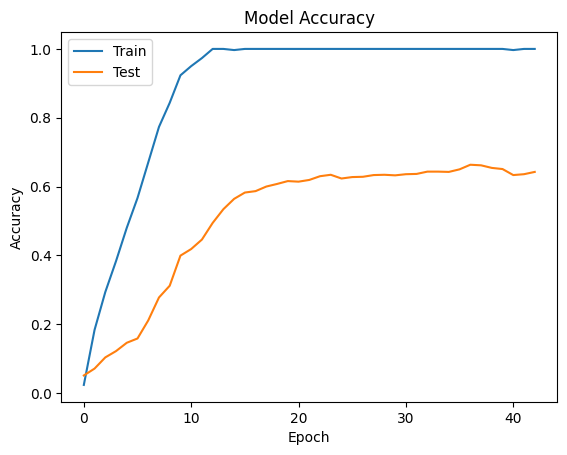

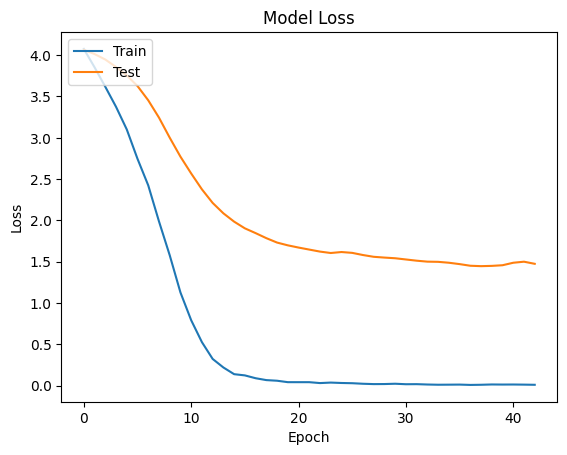

In [ ]:
history = model7.fit(
    x = reduced_train_data,
    epochs=50,
    validation_data=val_data,
    callbacks=[early_stopping, model_checkpoint]
)

test_loss, test_accuracy = model7.evaluate(val_data)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)


# Plot training and test accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training and test loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()